# 🔮 ➡️ Assignment 5: Shift-Reduce Dependency Parser
In this assignment, you'll be implementing a dependency parser using the Shift-Reduce algorithm described in Lecture 17. In Part 1, you'll implement the basic algorithm, with a dummy "oracle" that just uses the ground-truth labels. Then, you'll train a classifier to act as an actual oracle in Part 2, and evaluate the results of that model in Part 3. Have fun shifting!

# [DO NOT EDIT] Setup

In [ ]:
!pip install torch tqdm numpy datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, tqdm, random
import numpy as np
from datasets import load_metric
from google.colab import output
output.enable_custom_widget_manager()
# from sklearn.metrics import classification_report
import spacy

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Basic Algorithm with Ground-Truth Oracle

Read through the following sections to understand the setup here, and then complete the TODO sections.

## Loading Data
The datasets for this assignment come in a particularly strange format, called CoNLL. We've handled parsing it, but we encourage you to check out the format so that you'll understand it if you ever need to work with it. All that you need to know is that `read_conll` returns a list of dictionaries, where each dictionary encodes a parsed sentence. Each dictionary has a `'word'` key, which maps to a list of words which make up the sentence, and `'head'` key, which maps to a list of integers, where the value at index `i` (zero-based) is the index (1-based) of the word that is word `i`'s head. The root word has a head value of `0`.  

So the sentence '1460 is awesome.' would have the words `['1460', 'is', 'awesome', '.']` (yes, the punctuation is included), with heads `[3, 3, 0, 3]`. Check out the visual below which illustrates the dependency parse (arrows going out of one word and into another mean that that first word is the head of the other):

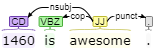 

As you can see, 'awesome' is the root word, and its head is hence the value `0`. 'awesome' is also the head of all of the other words, you can see this since the `'head'` values corresponding to the other words are all `3`, which is the 1-based index of the word 'awesome' in the word list!

In [ ]:
def read_conll(in_file, lowercase=False, max_example=None):
  examples = []
  with open(in_file) as f:
    word, pos, head, label = [], [], [], []
    for line in f.readlines():
      sp = line.strip().split('\t')
      if len(sp) == 10:
        if '-' not in sp[0]:
          word.append(sp[1].lower() if lowercase else sp[1])
          pos.append(sp[4])
          head.append(int(sp[6]))
          label.append(sp[7])
      elif len(word) > 0:
        examples.append({'word': word, 'pos': pos, 'head': head, 'label': label})
        word, pos, head, label = [], [], [], []
        if (max_example is not None) and (len(examples) == max_example):
          break
    if len(word) > 0:
      examples.append({'word': word, 'pos': pos, 'head': head, 'label': label})
  return examples

### Dataset objects
Since this assignment uses Pytorch modules as the classifiers for the shift-reduce algorithm, we'll make a dataset child class for our data, such that we can eventually make PyTorch Dataloaders (just as in assignment 3)!

**VERY IMPORTANT:**


We need to train models using supervised learning to drive our shift-reduce algorithm. To do this, we'll break the parsing of an entire sentence down into steps, called _partial parses_. At each step a classifier will have to decide, given some features, whether to arc left, arc right, or shift. Each partial parse can be labeled with the correct action, and we can train the model to execute partial parses as well as possible!

The input to our model is a set of features, from which the correct partial parse is to be predicted. Our model will use learned word embeddings, and will classify between three classes. The model will have an embedding layer, which can be used to fetch learned embeddings for words, based on their ID. As such, the model takes some number of integers, each less than the length of the vocabulary, as input. 

An 'instance' is a labeled partial parse, where the last value is the label, and the previous values represent word IDs, which we'll use as features for the classifier. 

In [ ]:
# def of Dataset child obj to use with DataLoader
class SRDataset(torch.utils.data.Dataset):
  def __init__(self, instances):
    self.labels = []
    self.seqs = []

    for i in instances:
      # convert labels to one-hot vectors
      l = np.zeros((3,))
      l[i[-1]] = 1
      self.labels.append(l)
      self.seqs.append(np.array(i[:-1]))
      
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {'inputs': self.seqs[idx], 'targets': self.labels[idx]}

## Defining Utility Functions
We're going to define several functions that will simplify our eventual shift-reduce code:

### word_to_id
Since we need to build up a vocabulary when training, and assign an ID/index to each word, we need some functions to handle doing so. We'll first define word_to_id, which when in `is_test=False` mode, both builds a vocabulary as well as returns the IDs of known words. When `is_test=True`, unknown words are not used to expand the vocabulary. 

In [ ]:
def word_to_id(word, vocab, is_test=False):
  """
  @param string word: the word in question
  @param Dictionary<String, int> vocab: vocabulary mapping words to their index/ID
  @param Boolean is_test: whether to operate in testing or training mode

  @return int: The index/ID of <word> 
  """

  if is_test:
    if word in vocab:
      return vocab[word]
    else:
      return vocab["<UNK>"]

  # otherwise, we're doing train:

  if word in vocab:
    if random.randint(0, 100) <= 2:
      return vocab['<UNK>'] # randomly mask this word for training example, otherwise <UNK> never trained on.
    return vocab[word]

  else: 
    n = len(vocab)
    vocab[word] = n
    return n

### Additional Helpers
Here are some other utility functions. You should find these useful when implementing some parts of this assignment later. 
- `get_root(heads)` returns the **index** of the root word in a list of 1-based indices pointing to the head of each word.
- `is_possible(action, stack, buf, root)` returns whether an action (arc or shift) is possible given the current stack, buffer, and root. This will be used in part 2 once we start training an oracle using machine learning.

In [ ]:
# returns the root word index
def get_root(heads):
  """
  @param List<int> heads: A list of 1-based indices pointing to the head of each word
  
  @return int: the 0-based index of the root word
  """
  root = 0
  for i, n in enumerate(heads):
    if n == 0:
      return i
  raise Exception(f'no root found for {heads}') # never happens with our data haha

# returns whether an action is possible, given the current stack, buffer, and root word.
def is_possible(action, stack, buf, root):
  """
  @param int action: 0 - arc left, 1 - arc right, 2 - shift
  @param List<int> stack: the shift-reduce stack
  @param List<int> buf: the shift-reduce buffer
  @param int root: the index of the root word in the sentence

  @return Boolean: Whether action is possible given stack and buffer state
  """
  if action == 2:
    if len(buf) != 0: 
      return True  
  elif len(stack) < 2: 
    return False
  elif action == 0:
    if stack[-2] != root: 
      return True
  else:
    return True
  return False

## Ground-Truth Dummy Oracle
This function has been written for you, please do not edit it! It takes the current stack, buffer, root word, as well as the full parse (read from the CoNLL), and returns the ground-truth correct action (arc left, arc right, or shift) to be taken by the Shift-reduce algorithm.

In [ ]:
def get_ground_truth_oracle(stack, buf, ex, root):
    """
    @param List<int> stack: the shift-reduce stack
    @param List<int> buf: the shift-reduce buffer
    @param _ ex: Raw training example dict produced by read_conll()
    @param int root: 0-based index of the root word

    @return int: action to apply in shift-reduce algorithm: 
    -> 0 - arc left, 1 - arc right, 2 - shift
    """
    if len(stack) < 2:
        return None if len(buf) == 0 else 2

    sf = stack[-1]
    ss = stack[-2]
    hf = ex['head'][sf] - 1
    hs = ex['head'][ss] - 1

    if ss != root and hs == sf: 
      return 0
    elif sf != root and hf == ss and (not any([x for x in buf if ex['head'][x] - 1 == sf])):
      return 1
    else:
      return None if len(buf) == 0 else 2

## TODO: get_bow_features
This is a featurization function - it takes in the stack, buffer, words to be parsed, and vocabulary (as well as an `is_test` flag) and returns a featurization to be passed to the classifier. This featurization should consist of some number of word IDs to be converted to embeddings.

You may decide how to featurize the stack and buffer such that the classifier executes partial parses with the best results possible. `stack` and `buf` are both lists of integers that represent indices of strings in the list `words`. Use these indices to get the corresponding word strings, and then use `word_to_id` to convert words to their IDs.

Keep in mind that you must always output the same number of features. If one of your features is the first word in the buffer, but the buffer is empty, you can provide the ID corresponding to the `'<NW>'` ('no word') token to fill its place! 

In [ ]:
def get_bow_features(stack, buf, words, vocab, is_test=False):
  """
  @param List<int> stack: the shift-reduce stack. stack[-1] is the top of the stack, stack[-2] is the second item
  @param List<int> buf: the shift-reduce buffer. buf[0] is the first item in the buffer
  @param List<String> words: words in the sentence, in order
  @param Dictionary<String, int> vocab: the word id vocabulary
  @param Boolean is_test: whether we are in testing mode (default: False)

  @return List<int>: featurized instance - some list of integers to be fed into a classifier
  Hint: use word_to_id on the items of the data structures.
  """

  features = []

  #TODO

  s, b = stack.copy(), buf.copy()
  s_features, b_features = [], []

  # Pre-define the size of bow features for stack and buffer
  buf_features_size = 4
  stk_features_size = 4

  # Process indexes in stack
  while len(s_features) < stk_features_size:
    if len(s_features) < len(stack):
      s_features.append(word_to_id(words[s.pop()], vocab, is_test))
    else:
      s_features.append(word_to_id('<NW>', vocab, is_test)) # Fill 'no word' if needed
  s_features = s_features[::-1]
  
  # Process indexes in buf
  while len(b_features) < buf_features_size:
    if len(b_features) < len(buf):
      b_features.append(word_to_id(words[b.pop(0)], vocab, is_test))
    else:
      b_features.append(word_to_id('<NW>', vocab, is_test)) # Fill 'no word' if needed

  features = b_features + s_features
  # print(b_features, s_features)

  return features

In [ ]:
#Feel free to test your bow_features here! Modify this example as much as you want
#original: "I prefer the morning flight through Denver ."
example = {'word': "I prefer the morning flight through Denver .".split(" "), 'head': [2, 0, 5, 5, 2, 7, 2, 2]}
fake_vocab = {'<UNK>': 0, '<NW>': 1, "I":2, "prefer":3, "the":4, "morning":5, "flight":6, "through":7, "Denver":8, ".":9}
#simulate some part of the process, edit stack and buf as you want
stack = [1]
buf = [0, 2, 3, 4, 5, 6, 7]
is_test=False
features = get_bow_features(stack, buf, example['word'], fake_vocab, is_test)
print(features)

[2, 4, 0, 0, 0, 1, 1, 3]


## TODO: oracle_shift_reduce
This is one of the two implementations of shift reduce in this assignment. It applies the regular shift-reduce algorithm to generate partial parses for training, as well as the correct arcs for a labeled example.

Apply the shift-reduce algorithm, making use of the functions `get_ground_truth_oracle`, `get_bow_features`, and `apply_action` (and possibly more!), in order to both produce a full parse of the input example as well as labeled partial parses. In other words, for each partial parse along the way, we want you to save that state in `instances` as a tuple with the featurization from your `get_bow_features` function, as well as the "gold" action produced by the ground-truth oracle. 

Remember to handle the case where `get_ground_truth_oracle` returns `None`.

In [ ]:
# Given the stack, buffer, and arcs, applies either a left arc, right arc,
# or shift (based on the action argument), and returns the new stack, buffer,
# and arcs.
def apply_action(stack, buf, arcs, action):
  """
  @param List<int> stack: the shift-reduce stack
  @param List<int> buf: the shift-reduce buffer
  @param List<Tuple<int, int>> arcs: the arcs produced by shift-reduce (of the form (head idx, word idx))
  @param int action: action to be taken: 0 - arc left, 1 - arc right, 2 - shift

  @return Tuple<List<int>, List<int>, List<Tuple<int, int>>>: updated stack, buffer, and arcs
  """

  #TODO

  if action == 0: # arc left
    arcs.append((stack[-1], stack[-2])) # create head-word relation
    stack.pop(-2) # remove 2nd word from stack
  
  if action == 1: # arc right
    arcs.append((stack[-2], stack[-1])) # create head-word relation
    stack.pop() # remove 1st word from stack

  if action == 2: # shift
    stack.append(buf.pop(0))

  return stack, buf, arcs

# executes the shift-reduce algorithm
def oracle_shift_reduce(example, vocab, is_test=False):
  """
  @param Dictionary<String, _> example: training example produced by read_conll
  @param Dictionary<String, int> vocab: the vocabulary/word2id dictionary
  @param Boolean is_test: whether the function's being used to generate training instances/arcs, or 
  testing instances/arcs.
  
  @return Dictionary<String, _>: {'instances': List<Tuple<int, ..., int>> [(*features, gold),...], 'arcs': List<Tuple<int, int>> gold arcs}
  """

  instances = []
  
  # initialize stack, buffer, and arcs
  root = get_root(example['head'])
  stack = [root]
  buf = [idx for idx in range(len(example['word'])) if idx != root]
  arcs = []

  #TODO

  while not (stack == [root] and buf == []):
    # Get action to be applied to features
    action = get_ground_truth_oracle(stack, buf, example, root)
    if action == None: break

    # Get current features
    features = get_bow_features(stack, buf, example['word'], vocab, is_test)

    # Updtate the instances
    instances.append((*features, action))

    # Update the stack, buf, arcs
    stack, buf, arcs = apply_action(stack, buf, arcs, action)

  # print(len(instances))
  return {'instances': instances, 'arcs': arcs}
  

# Part 2: Machine Learned Oracle
Above, you implemented a version of shift-reduce that assumed you had a ground-truth oracle. Of course, in practice, you will never have this! So, in order to run your parser on unseen data, you will need to implement another version of the oracle--this time using machine learning! 

## generate_instances
First, we need to get training data to train our machine-learned oracle. To do this, we can use our ground truth oracle from above to generate training/testing instances (labeled partial parses) for us to train our classifier on. This essentially entails applying `oracle_shift_reduce` to every example in the raw data.

In [ ]:
def generate_instances(raw_data, vocab, is_test=False):
  """
  @param _ raw_data: a list of example parses loaded with read_conll
  @param Dictionary<String, int> vocab: the vocabulary to use
  @param Boolean is_test: testing or training?
  
  @return List<Tuple<*features, gold>>: list of labeled partial parses
  """

  instances = []

  progress_bar = tqdm.notebook.tqdm(range(len(raw_data)))

  for parse in raw_data: # for each labelled parse...
    
    instances += oracle_shift_reduce(parse, vocab, is_test)['instances'] # get generated instances
    
    progress_bar.update(1)

  return instances

## TODO: SRClassifier
Now, let's design a simple neural classifier to train on the partial parse classifiation task. 

It needs to have an embedding layer of size `vocab_size`, with embedding dimension of your choosing. Depending on the number of features you have, you might want to get embeddings for each token/feature and then concatenate those embeddings together. We've provided a `num_features` argument such that you can make your classifier work with any number of input word IDs (which will make your life easier if you use it). Then, it's going to need several linear layers and activation functions, eventually ending with three output classes. In `forward`, we need to specify how the model will be applied to input features. 

PyTorch documentation will be very helpful here! You should look at the `torch.nn.Embedding` layer for word embeddings, you may find the examples helpful in figuring out what to do with its output. 

In [ ]:
import torch.nn as nn
# model that takes input in format given by SRDataset
class SRClassifier(torch.nn.Module):
    def __init__(self, vocab_size, num_features):
        super(SRClassifier, self).__init__()

        #TODO

        self.num_features = num_features
        self.embed_size = vocab_size
        self.n_classes = 3 # arc left, arc right, shift
        self.hidden_size_1 = 64
        self.hidden_size_2 = 16

        self.embedding = nn.Embedding(embedding_dim=32, num_embeddings=self.embed_size)

        self.hidden_1 = nn.Linear(in_features=self.num_features*32, out_features=self.hidden_size_1) 
        nn.init.xavier_uniform_(self.hidden_1.weight, gain=1)
        self.dropout_1 = nn.Dropout(p=0.2)
      
        self.hidden_2 = nn.Linear(in_features=self.hidden_size_1, out_features=self.hidden_size_2)
        nn.init.xavier_uniform_(self.hidden_2.weight, gain=1)
        self.dropout_2 = nn.Dropout(p=0.1)

        self.logits = nn.Linear(in_features=self.hidden_size_2, out_features=self.n_classes)
        nn.init.xavier_uniform_(self.logits.weight, gain=1)

    def forward(self, inputs, targets=None): # notice that the arg names need to match SRDataset.__getitem__() keys

        #TODO - Pass inputs (numpy array of word indices) through your classifier

        embedding = torch.flatten(self.embedding(inputs), start_dim=1)
        seq_1 = self.dropout_1(torch.relu(self.hidden_1(embedding)))
        seq_2 = self.dropout_2(torch.relu(self.hidden_2(seq_1)))
        outputs = self.logits(seq_2)

        return {'output': outputs, 'labels': targets}

## TODO: Training the classifier
Let's initialize some required data that will be used in training. This includes our vocabulary, which will be built when loading training data. By default, the vocabulary should map `'<UNK>'` and `'<NW>'` to start.

In [ ]:
vocabulary = {'<UNK>': 0, '<NW>': 1}

We load the training data using `read_conll`, generate training instances using `generate_instances` and instantiate a `SRDataset` object with them. Finally, create a dataloader with the `SRDataset` object - the batch size can be very high, but if you somehow run out of memory, you should decrease it. *Nothing TODO here!*

In [ ]:
PATH = "/content/drive/MyDrive/CSCI1460/Assignment_5/"
raw_training_data = read_conll(PATH + 'train.conll')

random.seed(1460) 
training_instances = generate_instances(raw_training_data, vocabulary)
random.shuffle(training_instances)
print(len(training_instances))

train_dataset = SRDataset(training_instances)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024)

  0%|          | 0/39832 [00:00<?, ?it/s]

1819698


In [ ]:
# At this point, each partial parse should be a n-tuple of integers. 
print(training_instances[:10])

[(856, 73, 4368, 40, 1, 1, 2961, 9, 1), (285, 7560, 15, 668, 1672, 3711, 1695, 11341, 0), (21082, 250, 0, 22, 1, 279, 2482, 250, 2), (13689, 895, 491, 22, 32889, 0, 180, 40, 2), (27, 498, 3137, 27, 2642, 24, 171, 85, 0), (27, 1629, 144, 100, 1, 47, 9, 4163, 2), (169, 2451, 147, 292, 1, 234, 451, 4322, 0), (1330, 68, 43, 1, 1398, 943, 90, 1342, 0), (27, 150, 77, 73, 1, 1, 1, 1538, 2), (169, 709, 394, 24, 1, 1, 0, 1187, 2)]


Next, let's instantiate our classifier and set up training hyperparameters and the optimizer.

In [ ]:
# setting up clf
device = torch.device('cuda')
# device = torch.device('cpu')

# TODO: fill in the number of features you are using (length of your get_bow_features output)
clf = SRClassifier(len(vocabulary), num_features=8) # instantiate classifier

# hyperparameters:
# TODO: Choose hyperparameters
# Note: Maybe start with ~4-5 epochs, it depends on your featurization - you'll likely have to play around with it
epochs = 5

# optimizer, device, and such
# AdamW works well... Try an initial learning rate of 5e-3. Again, you may find that tuning this gives 
# you better performance!
learning_rate = 5e-3
optimizer = torch.optim.Adam(clf.parameters(), lr=learning_rate)
clf.to(device)

SRClassifier(
  (embedding): Embedding(44384, 32)
  (hidden_1): Linear(in_features=256, out_features=64, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (hidden_2): Linear(in_features=64, out_features=16, bias=True)
  (dropout_2): Dropout(p=0.1, inplace=False)
  (logits): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
def train(model, dataloader, epochs, optimizer, metric_names):
  model.train()
  loss_func = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    print(f"epoch {epoch}")
    progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

    metrics = [load_metric(x) for x in metric_names]

    for batch in dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}

      outputs = model(**batch)

      loss = loss_func(outputs['output'], outputs['labels'])
      loss.backward()

      predictions = torch.argmax(outputs['output'], dim=1)
      references = torch.argmax(outputs['labels'], dim=-1)

      for metric in metrics:
        metric.add_batch(predictions=predictions, references=references)

      optimizer.step()
      optimizer.zero_grad()
      progress_bar.update(1)

    for metric in metrics:
      print(metric.compute())


Finally, set up some metrics, and train!

In [ ]:
metrics = ['accuracy']

train(clf, train_dataloader, epochs, optimizer, metrics)

epoch 0


  0%|          | 0/1778 [00:00<?, ?it/s]

<ipython-input-17-49c9229cbfdd>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_names]


{'accuracy': 0.8382028226661786}
epoch 1


  0%|          | 0/1778 [00:00<?, ?it/s]

{'accuracy': 0.8965795423196596}
epoch 2


  0%|          | 0/1778 [00:00<?, ?it/s]

{'accuracy': 0.912024412842131}
epoch 3


  0%|          | 0/1778 [00:00<?, ?it/s]

{'accuracy': 0.9209846908662866}
epoch 4


  0%|          | 0/1778 [00:00<?, ?it/s]

{'accuracy': 0.9271934134125552}


## Evaluating the classifier
We can evaluate the classifer to get an idea of its accuracy before we use it as an oracle in the shift-reduce algorithm. First, load the testing data and generate the testing instances, afterwhich you should instantiate `SRDataset` and `DataLoader` objects similarly to when training. REMEMBER: Now that we're testing, we don't want to augment the vocabulary, thus we pass `is_test=True` to `generate_instances`.

In [ ]:
PATH = "/content/drive/MyDrive/CSCI1460/Assignment_5/"
test_data = read_conll(PATH + 'test.conll')

# for i in range(20):
#   print(" ".join(test_data[i]['word']))

test_instances = generate_instances(test_data, vocabulary, is_test=True) # is_test is true here!

test_dataset = SRDataset(test_instances)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

  0%|          | 0/2416 [00:00<?, ?it/s]

In [ ]:
def evaluate(model, dataloader, metric_names):
  model.eval()

  metrics = [load_metric(metric) for metric in metric_names]

  print("evaluation: ")
  progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

  for batch in dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    predictions = torch.argmax(outputs['output'], dim=1)
    references = torch.argmax(outputs['labels'], dim=-1)

    for metric in metrics:
      metric.add_batch(predictions=predictions, references=references)
    
    progress_bar.update(1)

  for metric in metrics:
    print(metric.compute())

We can evaluate the model to assess its performance at correctly executing partial parses!

In [ ]:
metrics = ['accuracy']
evaluate(clf, test_dataloader, metrics)

evaluation: 


  0%|          | 0/424 [00:00<?, ?it/s]

{'accuracy': 0.9165230375033411}


# Part 3: Evaluation and Visualization

Ok, so we've evaluated the classifier, and it seems to perform well. However, the accuracy score it recieved above doesn't quite represent the performance of our algorithm overall when it is actually applied. To measure this, we use something called UAS - **Unlabeled Attachment Score**. UAS measures the proportion of correctly assigned heads in a full parse. So far, we've only really been considering partial parses. Since a full parse requires sequentially executing partial parses, if one partial parse is wrong, it could influence future partial parses and lead to further incorrect partial parses. Thus, we'd expect our UAS to be *worse* than the accuracy we previously saw, which is more reflective of how well the algorithm is actually doing.

First we need to use our classifier to obtain full parses. 

## TODO: model_shift_reduce
Here, we define a version of shift-reduce that consults an SRClassifier, rather than the oracle from Part 1, in order to determine which actions to apply. Use as many helpers from above as needed to write these. 

In [ ]:
# takes a prediction (tensor), current stack, buffer, and root index, and finds the highest probability action that is possible
def get_action(pred, stack, buf, root):
  """
  @param torch.Tensor pred: predicted tensor, output of a torch.nn.Module usually.
  @param List<int> stack: the shift-reduce stack
  @param List<int> buf: the shift-reduce buffer
  @param int root: index of root word

  @return int: action: 0 - arc left, 1 - arc right, 2 - shift
  """

  # TODO

  # Get the indexes of the probabilities in descending order
  _, actions = torch.topk(pred, pred.shape[0])
  # print(pred, indexes, pred.shape)
  for action in actions.tolist():
    if is_possible(action, stack, buf, root):
      return action
  return None

# executes the shift-reduce algorithm on the given example, deciding which action to take by 
# consulting the model
def model_shift_reduce(model, example, vocab):
  """
  @param SRClassifier model: An SRClassifier to use for shift-reduce
  @param _ example: a training example produced by read_conll
  @param Dictionary<String, int> vocab: our word2id vocabulary

  @return List<Tuple<int, int>>: the arcs of the dependency parse tree
  """

  #TODO

  # initialize stack, buffer, and arcs
  root = get_root(example['head'])
  stack = [root]
  buf = [idx for idx in range(len(example['word'])) if idx != root]
  arcs = []

  #TODO

  while not (stack == [root] and buf == []):

    # Get Bow Features
    features = get_bow_features(stack, buf, example['word'], vocab, is_test=True)

    # Get probabilities
    pred = model(torch.tensor(features).to(device).view(1,-1))['output'] # torch.Size([1, 3])
    pred = torch.squeeze(pred) # torch.Size([3])

    # Get action to be applied to features
    action = get_action(pred, stack, buf, root)
    # print(action)
    if action == None: break

    # Update the stack, buf, arcs
    stack, buf, arcs = apply_action(stack, buf, arcs, action)

  return arcs


## Calculating UAS
Now that we can directly compare the true parse to the model's parse, we can tackle evaluating the UAS. To evaluate UAS, we compute both the correct and predicted parses for each testing phrase. Then we, average these scores across all testing phrases and output the result as UAS of the model on the testing set. This has been implemented for you.

In [ ]:
def evaluate_UAS(clf, test_examples, vocab):
  """
  @param torch.nn.Module clf: a classifier
  @param _ test_examples: test examples loaded with read_conll
  @param Dictionary<String, int> vocab: our word2id vocabulary

  @return float: UAS of clf on test_examples
  """

  # initialize some counters for keeping track of UAS.
  acc = 0
  count = 0

  keep = []

  progress_bar = tqdm.notebook.tqdm(range(len(test_examples)))

  for i, example in enumerate(test_examples):

    # first, get the correct parse
    arcs = oracle_shift_reduce(example, vocab, is_test=True)['arcs']

    # now let the classifier try...
    test_arcs = model_shift_reduce(clf, example, vocab)

    # if i < 10: print(arcs, test_arcs)

    # UAS for this example, number of common arcs over total arcs
    n = len(example['word'])
    s = len([arc for arc in test_arcs if arc in arcs]) / ((n - 1) if n != 1 else 1)
    acc += s
    count += 1
    progress_bar.update(1)
    
  return acc / count

### Baseline UAS
Of course, we'd have no idea if our model was useful if we didn't evaluate a baseline model too. The baseline model should output something of the same format as the `SRClassifer`, except it just outputs a tensor with randomly ordered values. 

In [ ]:
# model that takes input in format given by SRDataset
class SRBaseline(torch.nn.Module):
    def __init__(self):
        super(SRBaseline, self).__init__()

    def forward(self, inputs):
        return {'output': torch.randperm(3)[None, :]}

## TODO: Final Scoring
Evaluate the baseline UAS and compare it to that of our model. For this function, directly use the CoNLL dataset as the argument to `test_examples`, not the dataloader we had used for training.

In [ ]:
# TODO: Fill in below!
model_uas = evaluate_UAS(clf, test_data, vocabulary)
baseline_model = SRBaseline()
baseline_uas = evaluate_UAS(baseline_model, test_data, vocabulary)
print(f"Model UAS: {model_uas}, baseline: {baseline_uas}")

  0%|          | 0/2416 [00:00<?, ?it/s]

  0%|          | 0/2416 [00:00<?, ?it/s]

Model UAS: 0.7941646332055914, baseline: 0.22814253437669693


The model should be over three times better than the baseline. For full credit, your model should have a UAS of over 70%, so you may need to make adjustments to your model, featurization, and hyperparameters in order to improve your score. If you submit with a UAS of under 70%, you'll recieve partial credit. 

# Part 4: Conceptual
Let's explore some of the parses visually. The following functions deal with reformating and displaying dependency parses. You'll only need to use `display_parse`, check its signature. Additionally, you'll be asked to compare the parses that your model creates with real parses.

## Helpers and examples

In [ ]:
import spacy
from spacy import displacy
from spacy.displacy.render import DependencyRenderer
from IPython.core.display import display, HTML


def reformat_dep(arcs, words):
  heads = list(range(len(words)))
  for arc in arcs:
    heads[arc[1]] = arc[0]
  return words, heads

def parse_for_displacy(doc, heads):
    #doc = ['word1', 'word2', ...]
    #heads = [idx_of_head_of_word1, idx_of_head_of_word2, ...]
    settings = {
        "lang": 'en',
        "direction": 'ltr',
    }
    words = [
        {
            "text": w,#w.text,
            "tag": '',#w.tag_ if fine_grained else w.pos_,
            "lemma": w#w.lemma_ if add_lemma else None,
        }
        for w in doc
    ]
    arcs = []
    for i,word in enumerate(doc):
        if i < heads[i]:
            arcs.append(
                {"start": i, "end": heads[i], "label": '', "dir": "left"}
            )
        elif i > heads[i]:
            arcs.append(
                {
                    "start": heads[i],
                    "end": i,
                    "label": '',
                    "dir": "right",
                }
            )
    return {"words": words, "arcs": arcs, "settings": settings}

def display_parse(arcs, words):
  """
  @param List<Tuple<int, int>> arcs: A list of arcs to display
  @param List<String> words: the words connected to by arcs
  """
  parsed=[parse_for_displacy(*reformat_dep(arcs, words))]
  renderer = DependencyRenderer()
  html = renderer.render(parsed, page=False, minify=False).strip()
  display(HTML('<span class="tex2jax_ignore">{}</span>'.format(html)))

Here's an example, where we try to parse the sentence "I prefer the morning flight through Denver.". Note that punctuation is treated as its own token here. Below is a brief summary of how you need to format punctuation and contractions such that they're in the same format as the training/testing data we used previously:

`"weren't" -> ["were", "n't"]`

`"Stock Market's" -> ["Stock", "Market", "'s"]`

`["'quoted text'"] -> ["``", "quoted", "text", "''"]`

`["22%"] -> ["22", "%"]`

`["$15"] -> ["$", "15"]`

Feel free to download `train.conll` or `test.conll` and take a peek at how the examples are tokenized. 

Additionally, we didn't do any lowercasing on the dataset, since it actually slightly harms performance on this task (think about why it might), so also don't do lowercasing when trying out your own sentences (see that "Denver" stays capitalized). 

In [ ]:
example = {'word': "I prefer the morning flight through Denver .".split(" "), 'head': [2, 0, 5, 5, 2, 7, 2, 2]}

model_arcs = model_shift_reduce(clf, example, vocabulary) # get the model's parse
true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True)['arcs'] # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['word'])
print("Actual parse:")
display_parse(true_arcs, example['word'])

Predicted parse:


Actual parse:


## TODO: Conceptual question

Now, come up with some of your own examples and visualize them! Try to find some scenarios where the parses your model produces aren't as accurate, **and comment on them**. A great tool to generate the correct parses is [this site](https://corenlp.run/) by CoreNLP. Select only 'dependency parse' in the annotation selection box, type in your examples, and hit 'Submit' to see the parses! 

Recall the format of the head list: The entry with value zero is the root word, and the entries at all other words are the 1-based index of their respective heads! In the example above, 'prefer' is the root word (thus has `0` as its head), so any word in the word list who's head is 'prefer' has a `2` as its head value (since 'prefer' is the second word), and so on. You'll need to encode the correct parse given by CoreNLP into the head list, so make sure to triple-check that you got it right.

If you take a look at the kinds of words frequently used in the training dataset (there's a theme, take a look), it may explain some behaviors.

TODO: Fill me in!!

In [ ]:
# TODO: 
example = {'word': "David wrote a blog post on NER evaluation .".split(" "), 'head': [2, 0, 5, 5, 2, 8, 8, 5, 2]}

model_arcs = model_shift_reduce(clf, example, vocabulary) # get the model's parse
true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True)['arcs'] # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['word'])
print("Actual parse:")
display_parse(true_arcs, example['word'])

'''
Predicted Parse: post -> David	
Actual Parse:  	 wrote -> David
'''

Predicted parse:


Actual parse:


In the graph above, some parses are not accurate:

|Predicted Parse|Actual Parse|
|:---:|:---:|
|post -> David| wrote -> David|
|||

In [ ]:
example = {'word': "We will test his library against Stanford Core NLP .".split(" "), 'head': [3, 3, 0, 5, 3, 9, 9, 9, 3, 3]}

model_arcs = model_shift_reduce(clf, example, vocabulary) # get the model's parse
true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True)['arcs'] # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['word'])
print("Actual parse:")
display_parse(true_arcs, example['word'])

'''
Predicted Parse: library -> NLP
Actual Parse:  	 test -> NLP
'''

Predicted parse:


Actual parse:


In the graph above, some parses are not accurate:

|Predicted Parse|Actual Parse|
|:---:|:---:|
|library -> NLP| test -> NLP|
|||

In [ ]:
example = {'word': "He uses this approach to evaluate sequential labelling tasks .".split(" "), 'head': [2, 0, 4, 2, 6, 2, 9, 9, 6, 2]}

model_arcs = model_shift_reduce(clf, example, vocabulary) # get the model's parse
true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True)['arcs'] # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['word'])
print("Actual parse:")
display_parse(true_arcs, example['word'])

'''
Predicted Parse: approach -> evaluate
Actual Parse:  	 uses -> evaluate
'''

Predicted parse:


Actual parse:


In the graph above, some parses are not accurate:

|Predicted Parse|Actual Parse|
|:---:|:---:|
|approach -> evaluate|uses -> evaluate|

# Submission

Download this notebook as a .ipynb file and submit it to Gradescope. Before doing so, additionally paste a link to your notebook in the text cell below.

**LINK TO THIS NOTEBOOK:** [My Notebook](https://colab.research.google.com/drive/1tcGRUeACknhrUNlqm8lkp6YVVceA_ci4?usp=share_link)